**Introductory and intermediate computing for Data Science [Barcelona School of Economics]**

`Instructor:` Maxim Fedotov  
`Program:` M.Sc. in Data Science Methodology

# Class 4

You will be very often working with several parameter values that you want to try. In machine learning it is a regular practice to do a "hyperparameter tuning", i.e. testing quality of your fit (based on some quantitative metric like MSE, MAE, ROC, AUC and so on) with respect to different values of your algorithm. 

Let's consider a bit simplified example: we want to compute a log-likelihood for a random sample that we have. We will be using `numpy` package here to get a random sample (see the class_5 notebook). In fact, it would be better to use `numpy.array` instead the one-dimensional `x` to vectorize computations (and get computation time gains), but for educational purposes we avoid that. Just keep it in mind.

In addition to that, you sometimes need *map* functions on collections of objects, and be able to write some small technical functions in a more concise way than a regular definition. We will also consider it in this notebook.

## Handling functions: map, lambda, functools.partial
First, define a function that computes normal pdf with parameters `mu` and `sigma` at point `x`.

In [1]:
from math import pi, log
from typing import Union
import numpy

numpy.random.seed(1337)  # for reproducibility

def log_normal_pdf(x: Union[float, int], mu: Union[float, int] = 0, 
                   sigma: Union[float, int] = 1) -> float:
    """
        Computes pdf of a normal distribution with parameters mu and sigma at point x.
        
        args:
            x:         concrete point
            mu:        mean parameter of the distribution
            sigma:     st.dev. parameter of the distribution
        
        returns:
            A value of pdf.
    """
    if sigma <= 0:
        raise ValueError("The parameter sigma has to be posititve.")
    return -(x - mu)**2 / (2 * sigma**2) - 0.5 * log(2 * pi * sigma**2)

log_normal_pdf(0)

-0.9189385332046727

### Map
Suppose now that we have a sample from an actual normal distribution. I convert it to a list for educational purposes of the current class since we have not seen `numpy` yet. In reality, you would try to use `numpy` objects and operations for such tasks (although difference is just in vectorizing operations, not in a conceptual approach).

In [2]:
x_sample = list(numpy.random.normal(1, 2, size=100))
x_sample[:10]

[-0.40637461972482103,
 0.019435274424570714,
 0.3563713406996948,
 -2.5101574342479736,
 1.413328940427661,
 -3.022529145629268,
 -0.11450141624788412,
 1.6744340168834113,
 4.097671943338812,
 -1.7414731165219255]

In [3]:
log_pdf_map = map(log_normal_pdf, x_sample)
log_pdf_map

Notice that the result has a specific type. However, it's still iterable (but not subscriptable), so you can transofm it to some more tractable sequence type, or you can just iterate through it using `for` loop.

In [4]:
log_pdf_sample = list(log_pdf_map)  # after you did that, log_pdf_map is now empty, see the explanation in the
log_pdf_sample[:10]                 # comment below

# for result in log_pdf_map:  # note that map is sort of generator, which means that when you iterate over its
#     print(result)           # elements, those ones that you have passed will be ERASED from memory

[-1.0015086989829192,
 -0.9191273981506518,
 -0.9824387994407217,
 -4.069383705559858,
 -1.91768788012986,
 -5.48677975129387,
 -0.9254938203660583,
 -2.320803171652831,
 -9.314396210817709,
 -2.4353028409889665]

### Lambda

Sometimes you need a tool to make up a function on the go to use it for some technical purposes rather than a "base" function for your computations. In this case, you can use `lambda` function definition. The syntax is the following:

```{Python}
lambda arg1, arg2 ...: code line
```

It is used to create one-line functions. You can also assign it to a variable, so you will be able to call it further.

Suppose that you want create a utility that to transform a data feature you use in your analysis. You can do it concisely like that:

In [5]:
female_indicator = lambda x: 1 if x == 'female' else 0

list(map(female_indicator, ["female", "male", "female", "male"]))

[1, 0, 1, 0]

In our case, we want to be able *map* our function `log_normal_pdf` to a list, and be able to set up the parameters `mu` and `sigma`. The built-in `map(...)` does not give us such functionality. So, we can try using `lambda` in combination with `map(...)` to achieve that.

In [6]:
log_pdf_map_customized = list(
    map(lambda x: log_normal_pdf(x, mu=1, sigma=2), x_sample)
)
log_pdf_map_customized[:10]

[-1.8593219101403848,
 -1.7322741113949702,
 -1.6638679451487066,
 -3.1522363654154075,
 -1.6334408153889997,
 -3.6346783046942344,
 -1.7673498896169355,
 -1.6689433691558047,
 -2.8115321473331742,
 -2.551545069841173]

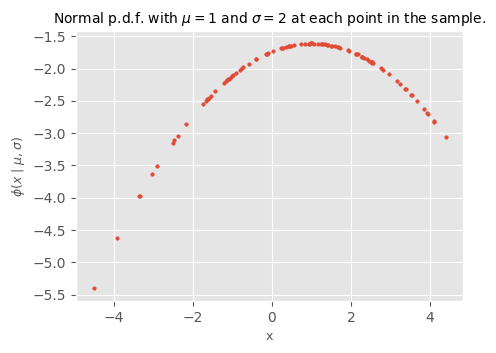

In [7]:
import matplotlib.pyplot as plt
import numpy

plt.style.use('ggplot')

indices = numpy.argsort(x_sample)
plt.figure(figsize=(5, 3.5))
plt.scatter(numpy.array(x_sample)[indices], numpy.array(log_pdf_map_customized)[indices], s=6)
plt.title(r"Normal p.d.f. with $\mu=1$ and $\sigma=2$ at each point in the sample.", size=10)
plt.xlabel("x", size=9)
plt.ylabel(r"$\phi (x\ |\ \mu, \sigma)$", size=9)
plt.show()

In fact, that is not the only way to do that. There is also package `functools` and function `partial` in there. In fact, it will be give computational gains with respect to `lambda` in the case when you want to specify only a part of parameters of a function and then be able to apply it to a collection of elements. So, `lambda` is better for the first case, where we need a technical utility which can be written in one line.

In [8]:
import functools

list(
    map(functools.partial(log_normal_pdf, mu=1, sigma=2), x_sample)
)[:10]

[-1.8593219101403848,
 -1.7322741113949702,
 -1.6638679451487066,
 -3.1522363654154075,
 -1.6334408153889997,
 -3.6346783046942344,
 -1.7673498896169355,
 -1.6689433691558047,
 -2.8115321473331742,
 -2.551545069841173]

Now, let's get back to our case. Now we should define a function that computes log-likelihood. The log-likelihood in that case would be:
$$l(\mathbf{x}\ |\ \mu, \sigma^2) = \sum_{i = 1}^{n} \log\phi(x_i\ |\ \mu, \sigma^2)$$
where $\mathbf{x} = (x_1, \ldots, x_n)^T$, $\phi(\cdot\ |\ \mu, \sigma^2)$ is a p.d.f. of a normal random variable with mean $\mu$ and variance $\sigma^2$.

In principle, we would try to do it with `numpy` means. 

But let's consider a built-in function `map(...)` which maps a function to each element of a collection. In future, I recommend to use it only when vectorization is not possible at all.

In this case, let's create a function which maps our `log_normal_pdf` function on a list, and returns a sum of the resulting elemens: this would be the likelihood.

In [9]:
def log_likelihood_normal(x: list, mu: Union[float, int] = 0, sigma: Union[float, int] = 1):
    log_pdf_individual = list(
        map(lambda x: log_normal_pdf(x, mu=mu, sigma=sigma), x)
    )
    return sum(log_pdf_individual)

In [10]:
log_likelihood_normal(x_sample, 1, 2)

-213.60930498592853

## Handling parameters: zip and itertools (and not only)

Now, we are moving towards exploring target values with respect to multiple vaulues of parameters. That is often the case in ML applications. To specify a range of possible parameters you can use the built-in function `zip(iterable1, iterable2...)`. The iterables passed should be of the same size. It produces a `zip` object which consists of tuples. The size of each tuple is the number of the passed iterables.

In [11]:
list(
    zip([1, 2, 3], [4, 5, 6])
)

[(1, 4), (2, 5), (3, 6)]

In our case, we could explore different parameter combinations with `zip(...)` like that:

In [12]:
mu_vals = [2] * 3 + [-2] * 3
sigma_vals = [1, 2, 3, 1, 2, 3]

for mu, sigma in zip(mu_vals, sigma_vals):
    log_pdf = log_likelihood_normal(x_sample, mu, sigma)
    print(f"The normal log-likelihood of the sample with mu = {mu}, sigma = {sigma} is {log_pdf}")

The normal log-likelihood of the sample with mu = 2, sigma = 1 is -382.4213235426839
The normal log-likelihood of the sample with mu = 2, sigma = 2 is -233.84043893201587
The normal log-likelihood of the sample with mu = 2, sigma = 3 is -234.03591221196905
The normal log-likelihood of the sample with mu = -2, sigma = 1 is -658.7231804052856
The normal log-likelihood of the sample with mu = -2, sigma = 2 is -302.9159031476663
The normal log-likelihood of the sample with mu = -2, sigma = 3 is -264.73611853003575


However, we do not explore a lot of parameters like that. So, it is often the case that you wish to use a *parameters grid*. To do that, you can use `product` function from the `itertools` package. It will give us a whole set of possible combinations (of a size of the number of passed iterables). You can think of it as a set product to some extent. Now, the iterables that we want to use to produce a grid do not have to be of the same size.

In [13]:
from itertools import product

mu_vals = range(-2, 5)
sigma_vals = range(1, 5)

param_grid = list(product(mu_vals, sigma_vals))

# let's store all the results
log_likelihood_vals = list(
    map(lambda par_tuple: log_likelihood_normal(x_sample, par_tuple[0], par_tuple[1]), param_grid)
)

index_max_loglik = numpy.argmax(log_likelihood_vals)
print("Parameters that give the best (in the specified range) log-likelihood:", param_grid[index_max_loglik])

Parameters that give the best (in the specified range) log-likelihood: (1, 2)


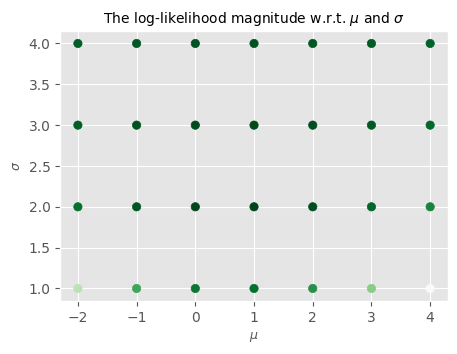

In [14]:
plt.figure(figsize=(5, 3.5))
plt.scatter([par_tuple[0] for par_tuple in param_grid], [par_tuple[1] for par_tuple in param_grid], 
            c=log_likelihood_vals, cmap='Greens')
plt.title(r"The log-likelihood magnitude w.r.t. $\mu$ and $\sigma$", size=10)
plt.xlabel(r"$\mu$", size=9)
plt.ylabel(r"$\sigma$", size=9)
plt.show()

# as we can see, log-likelihood values in this region are pretty close to each other.